# Cypher index development

This part of the research will focus on experiments with fulltext index and vector index on BAAI embeddings.
We aim to perform preliminary analysis on the performance of each index and use these learnings for further development.

## Tools

In [272]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import json
from IPython.display import SVG, display

from llama_index.embeddings.huggingface import HuggingFaceEmbedding

from utils.generic import get_driver, Models

In [89]:
driver = get_driver()

## Baseline: fulltext index search

Before running any complex experiments, we need a baseline to compare to. We believe a simple search by a keyword can be used as a baseline.
We will need to create a fulltext index on our knowledge graph - and then run it on the whole dataset.

In [3]:
create_fulltext_inde_query = """
    CREATE FULLTEXT INDEX diseaseIndex FOR (n:Disease) ON EACH [n.DiseaseName, n.Synonyms]
    OPTIONS {
        indexConfig: {
            `fulltext.analyzer`: 'english',
            `fulltext.eventually_consistent`: true
        }
    }
"""

In [7]:
with driver.session() as session:
    session.run(create_fulltext_inde_query)

In [202]:
df = pd.read_csv('../data/processed/ncbi_specific_disease.csv', sep=',')

In [512]:
def fulltext_search(disease_name, limit=1):
    with driver.session() as session:
        query = """
            CALL db.index.fulltext.queryNodes('diseaseIndex', $disease_name)
            YIELD node, score
            RETURN node.DiseaseID AS MESH_ID, node.AltDiseaseIDs as AltDiseaseIDs, node.DiseaseName AS Description, node.Synonyms AS Synonyms, score
            LIMIT $limit
        """
        result = session.run(query, disease_name=disease_name, limit=limit)

        return [{
            'MESH_ID': record['MESH_ID'],
            'Description': record['Description'],
            'Synonyms': record['Synonyms'],
            'AltDiseaseIDs': record['AltDiseaseIDs'],
            'score': record['score']} for record in result
        ]

The presence of special characters in the search string will be causing issues with the Lucene query parser used by Neo4j's fulltext search. In order to make it work, we will escape them in the search query using a regexp.

In [513]:
def predict_with_fulltext_index(dataset, limit=1):
    true_values = []
    predicted_values = []

    for _, row in dataset.iterrows():
        disease_name = row['Description']
        true_mesh_id = row['MESH ID']

        disease_name_re = re.sub('[^A-Za-z0-9 ]+', '', disease_name)
        
        predicted_ids = fulltext_search(disease_name_re, limit)
        
        true_values.append({"MESH_ID": true_mesh_id, "Description": disease_name})
        predicted_values.append(predicted_ids if len(predicted_ids) > 0 else [{"MESH_ID": "Unknown", "AltDiseaseIDs": "Unknown", "Description": "Unknown"}])

    return true_values, predicted_values

In [514]:
[true_values, predicted_values] = predict_with_fulltext_index(df)

And now we can calculate the performance. However, we know that "MESH_ID" field can be either one ID ("MESH:1234") or two IDs ("MESH:1234|MESH:5678"), and vise verse the predicted values can be the same. We will treat partial match as a correct prediction, e.g. if the true label is "MESH:1234|MESH:5678" and predicted label is "MESH:1234" - this should be treated as correct. We need to write a custom function for that.

In [340]:
def extract_ids(entry):
    mesh_ids = entry['MESH_ID'].split('|') if entry['MESH_ID'] else []
    alt_disease_ids = []

    if 'AltDiseaseIDs' in entry.keys() and entry['AltDiseaseIDs'] is not None and not pd.isna(entry['AltDiseaseIDs']):
        alt_disease_ids = entry['AltDiseaseIDs'].split('|')

    all_ids = mesh_ids + alt_disease_ids
    unique_ids = list(set(all_ids)) 
    
    return unique_ids

def partial_match(true_labels, predicted_labels):
    true_set = set(extract_ids(true_labels))
    predicted_set = set(extract_ids(predicted_labels[0]))

    return not true_set.isdisjoint(predicted_set)

def custom_accuracy(true_values, predicted_values):
    true_positive = 0
    
    for true_labels, predicted_labels in zip(true_values, predicted_values):
        if partial_match(true_labels, predicted_labels):
            true_positive += 1
        
    return true_positive / len(true_values) if len(true_values) > 0 else 0

In [337]:
custom_accuracy(true_values=true_values, predicted_values=predicted_values)

0.52520366598778

This is a baseline performance that we will take into account when developing further experiments. However, accuracy alone won't be sufficient to truly measure the performance of our system. Additionally to accuracy, we will be relying on MRR (Mean Reciprocal Rank) and Hits@N, which are commonly used in information retrieval and ranking tasks, making them well-suited for evaluating an entity linking system with a knowledge graph. MRR is the average of the reciprocal ranks of results for a set of queries. The reciprocal rank is the multiplicative inverse of the rank of the first correct answer. Hits@N measures the proportion of queries for which the correct entity is found within the top N ranked positions.

## Vector index: on DiseaseName prop

A vector index is a single-label, single-property index for nodes or a single-relationship-type, single-property index for relationships, and it can be used to index nodes or relationships by LIST<INTEGER | FLOAT> properties valid to the dimensions and vector similarity function of the index. We will start with creating a vector index for `DiseaseName` prop on `DiseaseEmbedding-BAAI-bge-small-en-v1_5` embedding and run it on the dataset with embedded `DiseaseName` property.

In [1]:
create_vector_index_query = """
    CREATE VECTOR INDEX baaiVectorIndex IF NOT EXISTS
    FOR (d:Disease)
    ON d.`DiseaseEmbedding-BAAI-bge-small-en-v1_5`
    OPTIONS {
        indexConfig: {
            `vector.dimensions`: 384,
            `vector.similarity_function`: 'cosine'
        }
    }
"""

In [5]:
with driver.session() as session:
    session.run(create_vector_index_query)

Now that we have our vector index, let us write functions to retrieve from it.

In [204]:
embed_model = HuggingFaceEmbedding(model_name=Models.BAAI_BGE_SMALL_EN_V1_5.value)

/Users/yuliana.romaniv/University/AstraZeneca/test-rag/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [471]:
baai_vector_index_query = """
    CALL db.index.vector.queryNodes('baaiVectorIndex', $limit, $disease_name)
    YIELD node AS disease, score
    RETURN disease.DiseaseName AS Description, disease.DiseaseID AS MESH_ID, disease.AltDiseaseIDs AS AltDiseaseIDs, disease.Synonyms AS Synonyms, score
"""

In [472]:
def vector_index_search(query, disease_name, limit=1, threshold=0.95):
    with driver.session() as session:
        result = session.run(query, disease_name=disease_name, limit=limit, threshold=threshold)

        return [{
            'MESH_ID': record['MESH_ID'],
            'Description': record['Description'],
            'Synonyms': record['Synonyms'],
            'AltDiseaseIDs': record['AltDiseaseIDs'],
            'score': record['score']} for record in result
        ]

In [190]:
test_name = embed_model.get_text_embedding('Hereditary deficiency of the fifth component of complement') # should match OMIM:609536
test_vector_search_res = vector_index_search(baai_vector_index_query, test_name, limit=1)

In [191]:
test_vector_search_res

[{'MESH_ID': 'MESH:C537005',
  'Description': 'Complement component 5 deficiency',
  'AltDiseaseIDs': 'DO:DOID:8158|OMIM:609536',
  'score': 0.9679043292999268}]

Since we're going to be using the disease name embeddings for queries, it's worth saving them to the dataset for better performance.

In [206]:
df['DiseaseEmbedding-BAAI-bge-small-en-v1_5'] = df['Description'].apply(lambda text: embed_model.get_text_embedding(text))

In [207]:
df.head()

,ID,Start,End,Description,Type,MESH ID,DiseaseEmbedding-BAAI-bge-small-en-v1_5
0,8808605,376,427,glucose-6-phosphate dehydrogenase (G6PD) defic...,SpecificDisease,MESH:D005955,"[-0.004877162165939808, -0.003928985446691513,..."
1,8808605,572,611,chronic nonspherocytic hemolytic anemia,SpecificDisease,MESH:D000746,"[-0.08520334213972092, 0.050464704632759094, -..."
2,8808605,677,692,G6PD deficiency,SpecificDisease,MESH:D005955,"[0.008812346495687962, -0.038349658250808716, ..."
3,8808605,1368,1383,G6PD deficiency,SpecificDisease,MESH:D005955,"[0.008812346495687962, -0.038349658250808716, ..."
4,9012409,112,149,Duarte enzyme variant of galactosemia,SpecificDisease,MESH:D005693,"[-0.062161244451999664, -0.027829371392726898,..."


In [208]:
df.to_csv('../data/processed/ncbi_specific_disease.csv', sep=',')

Now we can define a function for searching with vector index.

In [473]:
def predict_with_vector_index(query, dataset, embedding_model_name, limit=1, threshold=0.95):
    disease_name_col = f"DiseaseEmbedding-{embedding_model_name.replace('.', '_').replace('/', '-')}"
    true_values = []
    predicted_values = []

    for _, row in dataset.iterrows():
        disease_name = row['Description']
        true_id = row['MESH ID']
        disease_name_embedding = row[disease_name_col]
        
        predicted_mesh_id = vector_index_search(query, disease_name_embedding, limit, threshold)
        
        true_values.append({"MESH_ID": true_id, "Description": disease_name})
        predicted_values.append(predicted_mesh_id if len(predicted_mesh_id) > 0 
                                else [{"MESH_ID": "Unknown", "Description": "Unknown", "Synonyms": "Unknown", "AltDiseaseIDs": "Unknown"}])

    return true_values, predicted_values

In [507]:
[true_values_vector, predicted_values_vector] = predict_with_vector_index(query=baai_vector_index_query, dataset=df, embedding_model_name=Models.BAAI_BGE_SMALL_EN_V1_5.value, limit=1)

In [339]:
custom_accuracy(true_values=true_values_vector, predicted_values=predicted_values_vector)

0.38391038696537677

## Preliminary results analysis

Having conducted search via two different methods, we can try to compare their performance and continue developing more sophisticated methods.
We were relying on the correct prediction of the Disease ID, however let us have a look at the predicted values more closely. We will choose a random slice for analysis.

In [199]:
true_values[270:275]

[{'MESH_ID': 'OMIM:612446|OMIM:610102',
  'Description': 'combined subtotal deficiencies of C6 and C7'},
 {'MESH_ID': 'OMIM:612446|OMIM:610102',
  'Description': 'Combined subtotal deficiency of C6 and C7'},
 {'MESH_ID': 'MESH:D001943', 'Description': 'breast cancer'},
 {'MESH_ID': 'MESH:D001943', 'Description': 'breast cancer'},
 {'MESH_ID': 'MESH:D001943', 'Description': 'breast carcinomas'}]

In [200]:
predicted_values[270:275]

[[{'MESH_ID': 'MESH:C567308',
   'AltDiseaseIDs': nan,
   'Description': 'C6 Deficiency, Subtotal',
   'score': 17.659700393676758}],
 [{'MESH_ID': 'MESH:C567308',
   'AltDiseaseIDs': nan,
   'Description': 'C6 Deficiency, Subtotal',
   'score': 17.659700393676758}],
 [{'MESH_ID': 'MESH:D000072656',
   'AltDiseaseIDs': nan,
   'Description': 'Breast Cancer Lymphedema',
   'score': 13.135173797607422}],
 [{'MESH_ID': 'MESH:D000072656',
   'AltDiseaseIDs': nan,
   'Description': 'Breast Cancer Lymphedema',
   'score': 13.135173797607422}],
 [{'MESH_ID': 'MESH:D018270',
   'AltDiseaseIDs': 'DO:DOID:3008',
   'Description': 'Carcinoma, Ductal, Breast',
   'score': 12.872967720031738}]]

In [194]:
predicted_values_vector[270:275]

[[{'MESH_ID': 'OMIM:613559',
   'Description': 'COMBINED OXIDATIVE PHOSPHORYLATION DEFICIENCY 7',
   'AltDiseaseIDs': 'DO:DOID:0111487',
   'score': 0.898398756980896}],
 [{'MESH_ID': 'MESH:C565374',
   'Description': 'Molybdenum Cofactor Deficiency, Complementation Group C',
   'AltDiseaseIDs': 'DO:DOID:0111166|OMIM:615501',
   'score': 0.904615044593811}],
 [{'MESH_ID': 'MESH:C565336',
   'Description': 'Breast Cancer 3',
   'AltDiseaseIDs': nan,
   'score': 0.9277100563049316}],
 [{'MESH_ID': 'MESH:C565336',
   'Description': 'Breast Cancer 3',
   'AltDiseaseIDs': nan,
   'score': 0.9277100563049316}],
 [{'MESH_ID': 'MESH:D001943',
   'Description': 'Breast Neoplasms',
   'AltDiseaseIDs': 'DO:DOID:1612|DO:DOID:3459|OMIM:114480',
   'score': 0.9347741603851318}]]

"combined subtotal deficiencies of C6 and C7" is marked in our dataset as a combination of two diseases - "OMIM:612446" and "OMIM:610102". From the data processing step we know that these IDs must be present in the knowledge graph, so let us try to identify them.

In [249]:
def get_disease_by_id(disease_id):
    query = """
        OPTIONAL MATCH (d:Disease)
        WHERE (d.DiseaseID IS NOT NULL AND ANY(id IN SPLIT(toString(d.DiseaseID), '|') WHERE id = $disease_id))
        OR (d.AltDiseaseIDs IS NOT NULL AND ANY(altId IN SPLIT(toString(d.AltDiseaseIDs), '|') WHERE altId = $disease_id))
        RETURN d.DiseaseName AS DiseaseName, d.DiseaseID AS DiseaseID, d.AltDiseaseIDs AS AltDiseaseIDs, d.Synonyms AS Synonyms
    """

    with driver.session() as session:
        result = session.run(query, disease_id=disease_id)

        return [{
            'DiseaseID': record['DiseaseID'],
            'DiseaseName': record['DiseaseName'],
            'AltDiseaseIDs': record['AltDiseaseIDs'],
            'Synonyms': record['Synonyms']
        } for record in result]

In [250]:
get_disease_by_id("OMIM:612446")

[{'DiseaseID': 'MESH:C567307',
  'DiseaseName': 'Complement Component 6 Deficiency',
  'AltDiseaseIDs': 'DO:DOID:0060299|OMIM:612446',
  'Synonyms': 'C6D|C6 Deficiency|C6 DEFICIENCY COMPLEMENT COMPONENT 6 DEFICIENCY, SUBTOTAL, INCLUDED|C6 DEFICIENCY, SUBTOTAL, INCLUDED'}]

In [251]:
get_disease_by_id("OMIM:610102")

[{'DiseaseID': 'MESH:C566443',
  'DiseaseName': 'Complement Component 7 Deficiency',
  'AltDiseaseIDs': 'DO:DOID:0060300|OMIM:610102',
  'Synonyms': 'C7D|C7 Deficiency'}]

Let us try to find them in a hierarchy of diseases.
NB: We are using Neo4J Desktop application to browse the knowledge graph manually.

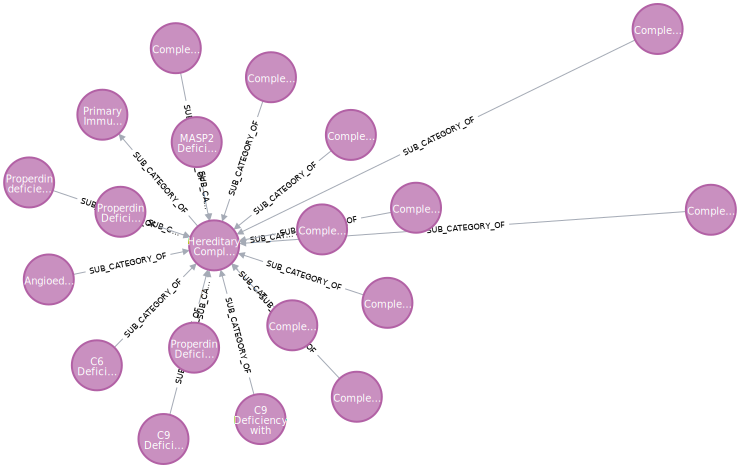

In [228]:
display(SVG(filename='./media/svg/Fig_1_combined_C6_and_C7_deficiencies.svg'))

As we can see, both disease are part of the larger group - "Hereditary Complement Deficiency Diseases" (MESH:D000081208
). Let us try to identify where the predicted diseases from the fulltext and vector indices are.

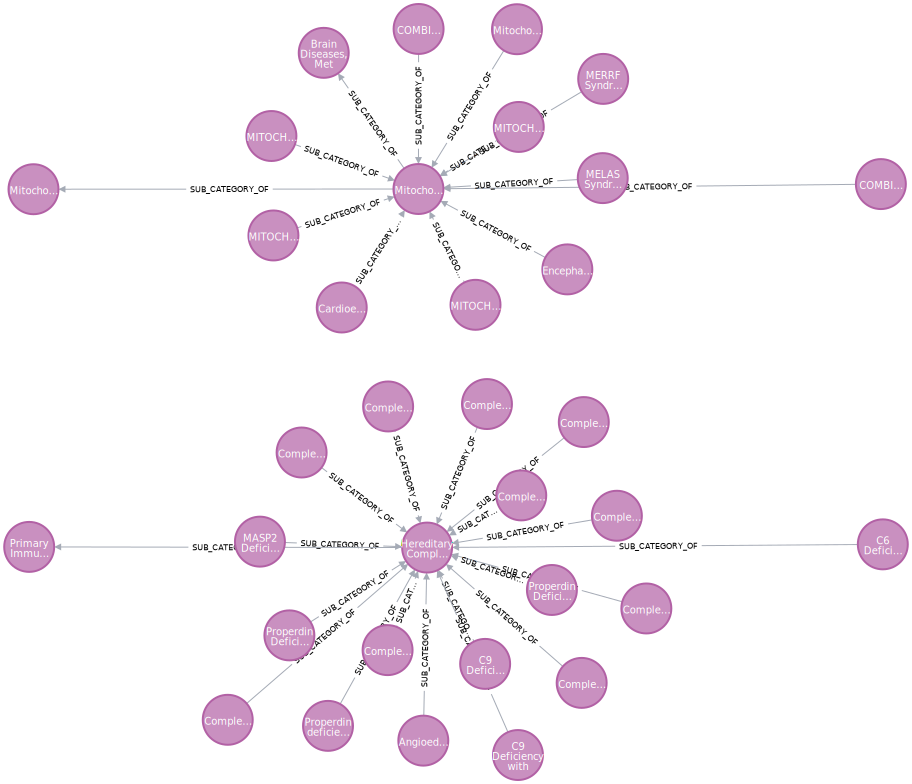

In [230]:
display(SVG(filename='./media/svg/Fig_2_combined_C6_and_C7_deficiencies.svg'))

As we can see, "C6 Deficiency, Subtotal" predicted by fulltext index is still a part of the same group, however, "COMBINED OXIDATIVE PHOSPHORYLATION DEFICIENCY 7" belongs to a different group - "Mitochondrial Encephalomyopathies" (MESH:D017237
), which makes it a worse candidate. Moreover, vector index search produced a different result when the same query was given - "Molybdenum Cofactor Deficiency, Complementation Group C", which belongs to a different from previous two disease groups, which may suggest that vector search works worse for disease names. 
Let us analyze one more prediction - "breast cancer".

In [252]:
get_disease_by_id("MESH:D001943")

[{'DiseaseID': 'MESH:D001943',
  'DiseaseName': 'Breast Neoplasms',
  'AltDiseaseIDs': 'DO:DOID:1612|DO:DOID:3459|OMIM:114480',
  'Synonyms': 'Breast Cancer|BREAST CANCER, FAMILIAL BREAST CANCER, FAMILIAL MALE, INCLUDED|Breast Carcinoma|Breast Carcinomas|Breast Malignant Neoplasm|Breast Malignant Neoplasms|Breast Malignant Tumor|Breast Malignant Tumors|Breast Neoplasm|Breast Tumor|Breast Tumors|Cancer, Breast|Cancer, Mammary|Cancer of Breast|Cancer of the Breast|Cancers, Mammary|Carcinoma, Breast|Carcinoma, Human Mammary|Carcinomas, Breast|Carcinomas, Human Mammary|Human Mammary Carcinoma|Human Mammary Carcinomas|Human Mammary Neoplasm|Human Mammary Neoplasms|Malignant Neoplasm of Breast|Malignant Tumor of Breast|Mammary Cancer|Mammary Cancers|Mammary Carcinoma, Human|Mammary Carcinomas, Human|Mammary Neoplasm, Human|Mammary Neoplasms, Human|Neoplasm, Breast|Neoplasm, Human Mammary|Neoplasms, Breast|Neoplasms, Human Mammary|Tumor, Breast|Tumors, Breast'}]

As we can see, "breast cancer" with "MESH:D001943" can be found as a "Breast Neoplasms" in our knowledge graph, however, "breast cancer" is listed as a synonym. Let us compare the findings for this in our two indices.

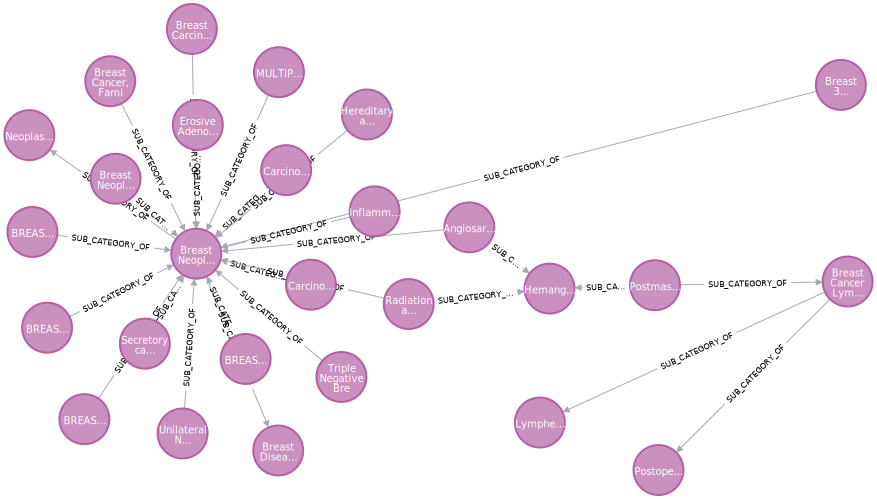

In [254]:
display(SVG(filename='./media/svg/Fig_3_breast_cancer.svg'))

This time the results are different:
- vector index prediction is better, as "Breast cancer 3" belongs to the category of "breast cancer", which was given as a query;
- vector index predicts the same value for the same input this time;
- fulltext index prediction is less accurate, but it is still connected via a different cancer category.

We cannot draw any conclusions just yet, but we can inspect one more aspect. We have written our index search queries with a fallback, so when a query cannot return any results - we get "Unknown" disease. Let us try to count how many unknowns each vector index produced.

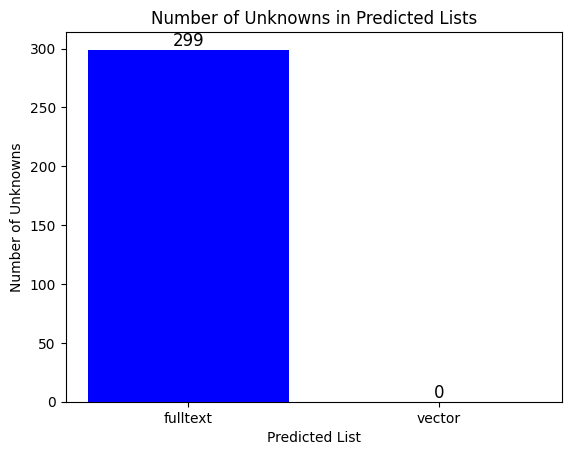

In [266]:
count_unknown_fulltext = sum(1 for item in predicted_values if item[0]['MESH_ID'] == 'Unknown')
count_unknown_vector = sum(1 for item in predicted_values_vector if item[0]['MESH_ID'] == 'Unknown')

labels = ['fulltext', 'vector']
unknown_counts = [count_unknown_fulltext, count_unknown_vector]

bars = plt.bar(labels, unknown_counts, color=['blue', 'orange'])
plt.title('Number of Unknowns in Predicted Lists')
plt.xlabel('Predicted List')
plt.ylabel('Number of Unknowns')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=12, color='black')

plt.show()

As we can see, the vector index always returns a value, no matter what input query it receives. It is both a strong side and a weakness of vector indices, and we should establish thresholds for it so the results are more realistic.

Up till this moment the fulltext index had a better performance, but this might be also due to the fact, that we included synonyms in it, whereas our vector index was relying purely on `DiseaseName` property. We identified, that some diseases from the dataset might map to one of the synonyms of the node, rather then its name, so let us experiment with vector index created on synonyms and compare the results.
The `SynonymEmbeddings` property already contains a list of embeddings (one for each synonym in the `Synonyms` property), so we have a few options for how to handle this when creating a vector index:

#### 1. **Create Separate Vector Indexes for Each Synonym Embedding**
   - Treat each embedding in the list as a separate vector and create individual vector indexes for each synonym embedding. This approach can become complex as it might involve creating multiple indexes, which could be cumbersome depending on the number of synonyms.

#### 2. **Combine Synonym Embeddings into a Single Embedding**
   - Combine the list of embeddings into a single embedding vector, which can then be indexed using a single vector index. This can be done by averaging the embeddings, taking the sum, or using a more sophisticated method like weighted averaging or pooling.

We will discard the first approach, as it is not scalable.

## Vector index: combine Synonym embeddings into a single embedding

First of all, we need to combine the synonyms vectors into a new prop on each node. There are nodes without synonyms, so for the sake of completeness, we will duplicate `DiseaseEmbedding` vector into this new property. We will calculate the centroid of the embeddings by taking the mean along the first axis across all vectors. Let us define the queries and functions to perform this operation.

In [525]:
create_baai_synonyms_combined_vector_index_query = """
    CREATE VECTOR INDEX baaiVectorIndex_combinedSynonym IF NOT EXISTS
    FOR (d:Disease)
    ON d.`SynonymsCentroidEmbedding-BAAI-bge-small-en-v1_5`
    OPTIONS {
        indexConfig: {
            `vector.dimensions`: 384,
            `vector.similarity_function`: 'cosine'
        }
    }
"""

get_baai_synonyms_combined_vector_index_query = """
    CALL db.index.vector.queryNodes('baaiVectorIndex_combinedSynonym', $limit, $disease_name)
    YIELD node AS disease, score
    RETURN disease.DiseaseName AS Description, disease.DiseaseID AS MESH_ID, disease.AltDiseaseIDs AS AltDiseaseIDs, disease.Synonyms AS Synonyms, score
"""

node_prop_update_query = """
    MATCH (d:Disease {DiseaseID: $disease_id})
    CALL apoc.create.setProperty(d, $embedding_prop, $embedding)
    YIELD node
    RETURN node
"""

batch_retrieve_query = """
    MATCH (d:Disease)
    RETURN d
    SKIP $skip LIMIT $limit
"""

In [286]:
def calculate_centroid(vectors):
    if not vectors:
        return None
    
    vectors_array = np.array(vectors)
    centroid = np.mean(vectors_array, axis=0)

    return centroid.tolist()

def update_disease_embeddings(driver, embedding_model_name, batch_size=100):
    embedding_prop = f"SynonymsCentroidEmbedding-{embedding_model_name.replace('.', '_').replace('/', '-')}"
    synonym_embeddings_prop = f"SynonymsEmbedding-{embedding_model_name.replace('.', '_').replace('/', '-')}"
    disease_embedding_prop = f"DiseaseEmbedding-{embedding_model_name.replace('.', '_').replace('/', '-')}"

    skip = 0
    
    with driver.session() as session:
        while True:
            result = session.run(batch_retrieve_query, skip=skip, limit=batch_size)
            nodes = list(result)

            # If no more nodes, break the loop
            if not nodes:
                break

            for record in nodes:
                node = record['d']
                disease_id = node['DiseaseID']
                synonym_embeddings_json = node.get(synonym_embeddings_prop, '[]')
                disease_embedding = node.get(disease_embedding_prop, None)

                # Decode the JSON-encoded embeddings
                synonym_embeddings = json.loads(synonym_embeddings_json)

                if synonym_embeddings:
                    centroid = calculate_centroid(synonym_embeddings)
                    embedding = centroid
                else:
                    # If no synonym embeddings, use the disease embedding
                    embedding = disease_embedding

                session.run(node_prop_update_query, disease_id=disease_id, embedding_prop=embedding_prop, embedding=embedding)

            # Increment the skip value to move to the next batch
            skip += batch_size

In [287]:
update_disease_embeddings(driver, Models.BAAI_BGE_SMALL_EN_V1_5.value)

In [291]:
with driver.session() as session:
    session.run(create_baai_synonyms_combined_vector_index_query)

Now that we have our combined embeddings, let us run the experiment.

In [294]:
test_synonym = embed_model.get_text_embedding('Breast Cancer-Related Arm Lymphedema') # this is a synonym of MESH:D000072656
test_vector_search_res = vector_index_search(get_baai_synonyms_combined_vector_index_query, test_synonym, limit=1)

In [296]:
test_vector_search_res

[{'MESH_ID': 'MESH:D000072656',
  'Description': 'Breast Cancer Lymphedema',
  'AltDiseaseIDs': nan,
  'score': 0.9633171558380127}]

In [526]:
[true_values_syn_vector, predicted_values_syn_vector] = predict_with_vector_index(query=get_baai_synonyms_combined_vector_index_query, dataset=df, embedding_model_name=Models.BAAI_BGE_SMALL_EN_V1_5.value, limit=1)

In [338]:
custom_accuracy(true_values=true_values_syn_vector, predicted_values=predicted_values_syn_vector)

0.31568228105906315

As we can see, the accuracy of such vector index in even lower, however, let us explore the previously analyzed diseases.

In [538]:
true_values[270:275]

[{'MESH_ID': 'MESH:D001943', 'Description': 'breast cancer'},
 {'MESH_ID': 'MESH:D001943', 'Description': 'breast cancer'},
 {'MESH_ID': 'MESH:D001943', 'Description': 'breast carcinomas'},
 {'MESH_ID': 'MESH:D001943', 'Description': 'breast cancer'},
 {'MESH_ID': 'MESH:D015783', 'Description': 'Aniridia'}]

In [527]:
predicted_values_syn_vector[270:275]

[[{'MESH_ID': 'MESH:D001943',
   'Description': 'Breast Neoplasms',
   'Synonyms': 'Breast Cancer|BREAST CANCER, FAMILIAL BREAST CANCER, FAMILIAL MALE, INCLUDED|Breast Carcinoma|Breast Carcinomas|Breast Malignant Neoplasm|Breast Malignant Neoplasms|Breast Malignant Tumor|Breast Malignant Tumors|Breast Neoplasm|Breast Tumor|Breast Tumors|Cancer, Breast|Cancer, Mammary|Cancer of Breast|Cancer of the Breast|Cancers, Mammary|Carcinoma, Breast|Carcinoma, Human Mammary|Carcinomas, Breast|Carcinomas, Human Mammary|Human Mammary Carcinoma|Human Mammary Carcinomas|Human Mammary Neoplasm|Human Mammary Neoplasms|Malignant Neoplasm of Breast|Malignant Tumor of Breast|Mammary Cancer|Mammary Cancers|Mammary Carcinoma, Human|Mammary Carcinomas, Human|Mammary Neoplasm, Human|Mammary Neoplasms, Human|Neoplasm, Breast|Neoplasm, Human Mammary|Neoplasms, Breast|Neoplasms, Human Mammary|Tumor, Breast|Tumors, Breast',
   'AltDiseaseIDs': 'DO:DOID:1612|DO:DOID:3459|OMIM:114480',
   'score': 0.959892034530639

This is an improvement for these particular diseases, and it shows a potential when combining with more complex queries and performing candidate ranking.

## Further results analysis

None of the approaches are not producing accurate results, so we will take a step back and examine the data once more. We have 2 obvious problematic patterns in the dataset:
- diseases with multiple IDs associated with them
- abbreviations that can correspond to different diseases

Let us analyze the multiple IDs entities first.

In [415]:
multiple_ids_df = df[df['MESH ID'].str.contains('|', regex=False)]
multiple_ids_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 270 to 3848
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   ID                                       35 non-null     int64 
 1   Start                                    35 non-null     int64 
 2   End                                      35 non-null     int64 
 3   Description                              35 non-null     object
 4   Type                                     35 non-null     object
 5   MESH ID                                  35 non-null     object
 6   DiseaseEmbedding-BAAI-bge-small-en-v1_5  35 non-null     object
dtypes: int64(3), object(4)
memory usage: 2.2+ KB


We have 35 entries. Let us drop the duplicates.

In [416]:
multiple_ids_df = multiple_ids_df.drop_duplicates(subset='Description', keep='first', ignore_index=False)
multiple_ids_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 270 to 3844
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   ID                                       25 non-null     int64 
 1   Start                                    25 non-null     int64 
 2   End                                      25 non-null     int64 
 3   Description                              25 non-null     object
 4   Type                                     25 non-null     object
 5   MESH ID                                  25 non-null     object
 6   DiseaseEmbedding-BAAI-bge-small-en-v1_5  25 non-null     object
dtypes: int64(3), object(4)
memory usage: 1.6+ KB


In [417]:
multiple_ids_df.head(25)

,ID,Start,End,Description,Type,MESH ID,DiseaseEmbedding-BAAI-bge-small-en-v1_5
270,8871666,19,62,combined subtotal deficiencies of C6 and C7,SpecificDisease,OMIM:612446|OMIM:610102,"[-0.017155997455120087, -0.010280901566147804,..."
271,8871666,128,169,Combined subtotal deficiency of C6 and C7,SpecificDisease,OMIM:612446|OMIM:610102,"[-0.01974971778690815, -0.00682515325024724, 0..."
300,8954016,86,102,renal hamartomas,SpecificDisease,MESH:D007674|MESH:D006222,"[-0.0009376744856126606, -0.011878404766321182..."
614,8188241,431,453,ochronotic arthropathy,SpecificDisease,MESH:D009794|MESH:D007592,"[-0.02016284689307213, -0.03807215392589569, 0..."
793,10417286,278,294,cleft lip/palate,SpecificDisease,MESH:D002971|MESH:D002972,"[-0.004606142640113831, -0.04793596640229225, ..."
794,10417286,296,300,CL/P,SpecificDisease,MESH:D002971|MESH:D002972,"[-0.10638944804668427, -0.005765229929238558, ..."
1331,23402,137,155,lamellar cataracts,SpecificDisease,MESH:C535342|OMIM:116800,"[-0.011170584708452225, 0.012628213502466679, ..."
1333,23402,745,773,bilateral lamellar cataracts,SpecificDisease,MESH:C535342|OMIM:116800,"[-0.009254563599824905, -0.0023286337964236736..."
1383,10571950,345,364,hereditary deafness,SpecificDisease,MESH:D030342|MESH:D003638,"[0.013537347316741943, -0.02739623188972473, 0..."
1557,10369860,247,263,cat-eye syndrome,SpecificDisease,MESH:C535918|OMIM:115470,"[-0.021985836327075958, -0.004197042901068926,..."


We can also drop Combined subtotal deficiency of C6 and C7 and cat eye syndrome as they were not removed as duplicates due to hyphen and a capital letter.

In [418]:
multiple_ids_df.drop(multiple_ids_df[multiple_ids_df.Description == 'Combined subtotal deficiency of C6 and C7'].index, inplace=True)
multiple_ids_df.drop(multiple_ids_df[multiple_ids_df.Description == 'cat-eye syndrome'].index, inplace=True)

In [419]:
multiple_ids_df.head(23)

,ID,Start,End,Description,Type,MESH ID,DiseaseEmbedding-BAAI-bge-small-en-v1_5
270,8871666,19,62,combined subtotal deficiencies of C6 and C7,SpecificDisease,OMIM:612446|OMIM:610102,"[-0.017155997455120087, -0.010280901566147804,..."
300,8954016,86,102,renal hamartomas,SpecificDisease,MESH:D007674|MESH:D006222,"[-0.0009376744856126606, -0.011878404766321182..."
614,8188241,431,453,ochronotic arthropathy,SpecificDisease,MESH:D009794|MESH:D007592,"[-0.02016284689307213, -0.03807215392589569, 0..."
793,10417286,278,294,cleft lip/palate,SpecificDisease,MESH:D002971|MESH:D002972,"[-0.004606142640113831, -0.04793596640229225, ..."
794,10417286,296,300,CL/P,SpecificDisease,MESH:D002971|MESH:D002972,"[-0.10638944804668427, -0.005765229929238558, ..."
1331,23402,137,155,lamellar cataracts,SpecificDisease,MESH:C535342|OMIM:116800,"[-0.011170584708452225, 0.012628213502466679, ..."
1333,23402,745,773,bilateral lamellar cataracts,SpecificDisease,MESH:C535342|OMIM:116800,"[-0.009254563599824905, -0.0023286337964236736..."
1383,10571950,345,364,hereditary deafness,SpecificDisease,MESH:D030342|MESH:D003638,"[0.013537347316741943, -0.02739623188972473, 0..."
1565,1424237,20,36,cat eye syndrome,SpecificDisease,MESH:C535918|OMIM:115470,"[-0.01026996597647667, -0.01579897664487362, -..."
1567,1424237,146,149,CES,SpecificDisease,MESH:C535918|OMIM:115470,"[-0.03191491588950157, 0.004478480201214552, 0..."


We can examine these diseases more closely. The biggest challenge is the "combined subtotal deficiencies of C6 and C7" entry, as it corresponds to 2 specific diseases. Named Entity Recognition is not a part of this research, so we can treat this project, so we will treat any prediction that matches either ID as a correct one. As for the rest - they seem to be denoting a singular disease, with some ids being from different ontologies (MESH vs OMIM), and some denoting disease category (like "MESH:D030342" - "Genetic Diseases, Inborn" in the knowledge graph, and "HEREDITARY MULTIFOCAL RELAPSING INFLAMMATION" or "HEMRI" in the dataset). This is the problem with the annotations, not a challenge our system should be tackling. Thus, we will remove those row and run more experiments.

We will also take a closer look at the abbreviations.

In [440]:
abbreviation_pattern = re.compile(r'\b(?!I{1,3}|IV|VI{0,3}|IX|X{1,3})[A-Z\.]{2,}s?\b') # excluding Roman numbers

def contains_abbreviation(description):
    return bool(abbreviation_pattern.search(description))

abbrev_df = df[df['Description'].apply(contains_abbreviation)]
abbrev_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1064 entries, 5 to 3922
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   ID                                       1064 non-null   int64 
 1   Start                                    1064 non-null   int64 
 2   End                                      1064 non-null   int64 
 3   Description                              1064 non-null   object
 4   Type                                     1064 non-null   object
 5   MESH ID                                  1064 non-null   object
 6   DiseaseEmbedding-BAAI-bge-small-en-v1_5  1064 non-null   object
dtypes: int64(3), object(4)
memory usage: 66.5+ KB


In [441]:
abbrev_df.head()

,ID,Start,End,Description,Type,MESH ID,DiseaseEmbedding-BAAI-bge-small-en-v1_5
5,9012409,1723,1749,LA variant of galactosemia,SpecificDisease,MESH:D005693,"[-0.03230331465601921, -0.0889873057603836, 0...."
8,8755645,471,474,FED,SpecificDisease,MESH:D007863,"[0.02004864625632763, -0.06878961622714996, 0...."
9,8755645,1168,1171,FED,SpecificDisease,MESH:D007863,"[0.02004864625632763, -0.06878961622714996, 0...."
51,8931701,167,170,WAS,SpecificDisease,MESH:D014923,"[-0.035743627697229385, 0.007720883935689926, ..."
52,8931701,662,665,WAS,SpecificDisease,MESH:D014923,"[-0.035743627697229385, 0.007720883935689926, ..."


Let us take a look at "WAS" - "Wiskott-Aldrich Syndrome". If we query the knowledge graph - we can see that the node for this particular diseases in fact contain "WAS" in the `Synonyms` prop, however querying `baaiVectorIndex_combinedSynonym` with the embedding for "WAS" results in "IMMUNE SUPPRESSION" disease with "IS|ISCW|ISSCW|STREPTOCOCCAL CELL WALL ANTIGEN, SUPPRESSION OF IMMUNE RESPONSE TO" and a score of 0.877177357673645 being returned. Querying `diseaseIndex` (a fulltext index) does not return any results, although that index was created on `DiseaseName` and `Synonyms` property. This can be solved by iterating over each synonym in each node, but the tradeoff would be a substantially longer runtime for such experiment.

In [446]:
was_df = pd.read_csv('./media/csv/cypher_index_query_was.csv', sep=",")
was_df.head()

,node.DiseaseName,node.Synonyms,node.DiseaseID,node.AltDiseaseIDs,score
0,"""IMMUNE SUPPRESSION""","""IS|ISCW|ISSCW|STREPTOCOCCAL CELL WALL ANTIGEN...","""OMIM:146850""",NaN,0.877177
1,"""Ataxia Telangiectasia""","""AT|AT1|ATA, INCLUDED|Ataxia-Telangiectasia|At...","""MESH:D001260""","""DO:DOID:12704|OMIM:208900""",0.874295
2,"""Aniridia""","""Absent Iris|AN|AN1|AN2|AN3|ANIRIDIA 1|ANIRIDI...","""MESH:D015783""","""DO:DOID:12271|OMIM:106210|OMIM:617141|OMIM:61...",0.871559
3,"""Epithelial Recurrent Erosion Dystrophy""","""Corneal Erosions, Recurring Hereditary|ERED""","""MESH:C565155""","""DO:DOID:0070337|OMIM:122400""",0.869163
4,"""HYPOMELANOSIS OF ITO""","""HMI|INCONTINENTIA PIGMENTI ACHROMIANS|INCONTI...","""OMIM:300337""","""DO:DOID:3156""",0.867288


So far we identified the following issues:
- with the existing queries, using the limit=1 it is not possible to collect the correct candidates with a decent accuracy;
- fulltext index is not reliable enough;
- vector index is more reliable, however, if the disease name is in the Synonyms, it is not guaranteed that the returned node will correspond to that disease even when using vector index created on synonyms centroids

Let us explore the results of the experiments focusing on the prediction score this time. We assume, that for a vector search anything with a score > 0.95 should produce the correct results. As for the fulltext search - should be at least > 10 points. We will remove all the entries from the dataset that contain multiple MESH/OMIM IDs for more precision.

In [459]:
df.drop(df[df['MESH ID'].str.contains('|', regex=False)].index, inplace=True)

In [460]:
df.to_csv('../data/processed/ncbi_specific_disease_singular_id.csv', sep=',')

## Manual Cypher query on each synonym

Having done simple index queries, let us try to compare the performance with a manual cypher query that would combine search on different properties.

In [477]:
manual_disease_synonyms_query = """
    MATCH (d:Disease)
    WITH d, apoc.map.get(d, 'SynonymsEmbedding-BAAI-bge-small-en-v1_5', '[]') AS synonym_embedding_json
    WITH d, apoc.convert.fromJsonList(synonym_embedding_json) AS synonym_embeddings
    UNWIND synonym_embeddings AS synonym_embedding
    WITH d, synonym_embedding, gds.similarity.cosine(synonym_embedding, $disease_name) AS score
    WHERE score > $threshold
    RETURN d.DiseaseName AS Description, d.Synonyms AS Synonyms, d.DiseaseID AS MESH_ID, d.AltDiseaseIDs AS AltDiseaseIDs, score
    ORDER BY score DESC
    LIMIT $limit
"""

We will verify if the query works correctly first.

In [483]:
test_synonym = embed_model.get_text_embedding('Breast Cancer-Related Arm Lymphedema') # this is a synonym of MESH:D000072656

In [484]:
with driver.session() as session:
    result = session.run(manual_disease_synonyms_query, disease_name=test_synonym, threshold=0.95, limit=10)

    for record in result:
        print(record)

<Record Description='Breast Cancer Lymphedema' Synonyms='Breast Cancer Lymphedemas|Breast Cancer Related Arm Lymphedema|Breast Cancer-Related Arm Lymphedema|Breast Cancer Related Lymphedema|Breast Cancer Treatment Related Lymphedema|Breast Cancer Treatment-Related Lymphedema|Lymphedema, Breast Cancer|Lymphedema, Post-mastectomy|Lymphedema, Postmastectomy|Lymphedemas, Postmastectomy|Post mastectomy Lymphedema|Post-mastectomy Lymphedema|Postmastectomy Lymphedema|Post-mastectomy Lymphedemas|Postmastectomy Lymphedemas' MESH_ID='MESH:D000072656' AltDiseaseIDs=nan score=1.0>
<Record Description='Breast Cancer Lymphedema' Synonyms='Breast Cancer Lymphedemas|Breast Cancer Related Arm Lymphedema|Breast Cancer-Related Arm Lymphedema|Breast Cancer Related Lymphedema|Breast Cancer Treatment Related Lymphedema|Breast Cancer Treatment-Related Lymphedema|Lymphedema, Breast Cancer|Lymphedema, Post-mastectomy|Lymphedema, Postmastectomy|Lymphedemas, Postmastectomy|Post mastectomy Lymphedema|Post-mastect

Now let us run this query on 10 entries in the dataset and store the results. We won't run it on the whole dataset as it is very computationally expensive.

In [485]:
test_df = df[:10]

In [ ]:
[true_values, predicted_values_syn_vector_manual] = predict_with_vector_index(query=manual_disease_synonyms_query, dataset=test_df, embedding_model_name=Models.BAAI_BGE_SMALL_EN_V1_5.value, limit=10, threshold=0.95)

As we can see, this solution is not scalable, as to run a single query on the entire knowledge base takes 3 minutes, and to query the whole dataset we would need more than 6 days. However, let us include these 10 results into the next phase of analysis.

## Further results analysis

Let us compare all 4 methods on the first 10 records.

In [528]:
print("True values")
print(true_values[0])
print("---------------")
print("Fulltext")
print(predicted_values[0])
print("---------------")
print("Vector disease name")
print(predicted_values_vector[0])
print("---------------")
print("Vector synonyms centroid name")
print(predicted_values_syn_vector[0])
print("---------------")
print("Vector synonyms manual")
print(predicted_values_syn_vector_manual[0])
print("---------------")

True values
{'MESH_ID': 'MESH:D005955', 'Description': 'glucose-6-phosphate dehydrogenase (G6PD) deficiency'}
---------------
Fulltext
[{'MESH_ID': 'MESH:D005955', 'Description': 'Glucosephosphate Dehydrogenase Deficiency', 'Synonyms': 'Deficiencies, G6PD|Deficiencies, Glucose-6-Phosphate Dehydrogenase|Deficiencies, Glucosephosphate Dehydrogenase|Deficiencies, GPD|Deficiency, G6PD|Deficiency, Glucose-6-Phosphate Dehydrogenase|Deficiency, Glucosephosphate Dehydrogenase|Deficiency, GPD|Deficiency of Glucose 6 Phosphate Dehydrogenase|Deficiency of Glucose-6-Phosphate Dehydrogenase|Dehydrogenase Deficiencies, Glucose-6-Phosphate|Dehydrogenase Deficiencies, Glucosephosphate|Dehydrogenase Deficiency, Glucose-6-Phosphate|Dehydrogenase Deficiency, Glucosephosphate|G6PD Deficiencies|G6PD Deficiency|Glucose-6-Phosphate Dehydrogenase Deficiencies|Glucose 6 Phosphate Dehydrogenase Deficiency|Glucose-6-Phosphate Dehydrogenase Deficiency|Glucosephosphate Dehydrogenase Deficiencies|GPD Deficiencies|G

As we can see, both the centroid vector value and manual vector similarity check on each individual synonym produced the same correct result. However, this might be due to the fact, that all the synonyms are very similar to each other, unlike in other cases, where a single disease can have a set of lexically different synonyms.

In [529]:
print("True values")
print(true_values[1])
print("---------------")
print("Fulltext")
print(predicted_values[1])
print("---------------")
print("Vector disease name")
print(predicted_values_vector[1])
print("---------------")
print("Vector synonyms centroid name")
print(predicted_values_syn_vector[1])
print("---------------")
print("Vector synonyms manual")
print(predicted_values_syn_vector_manual[1])
print("---------------")

True values
{'MESH_ID': 'MESH:D000746', 'Description': 'chronic nonspherocytic hemolytic anemia'}
---------------
Fulltext
[{'MESH_ID': 'MESH:D000746', 'Description': 'Anemia, Hemolytic, Congenital Nonspherocytic', 'Synonyms': 'Anemia, Congenital Nonspherocytic Hemolytic|Anemia, Hemolytic Congenital, Nonspherocytic|Congenital Nonspherocytic Hemolytic Anemia|Hemolytic Anemia, Congenital Nonspherocytic', 'AltDiseaseIDs': 'DO:DOID:2861', 'score': 23.652645111083984}]
---------------
Vector disease name
[{'MESH_ID': 'MESH:D000746', 'Description': 'Anemia, Hemolytic, Congenital Nonspherocytic', 'Synonyms': 'Anemia, Congenital Nonspherocytic Hemolytic|Anemia, Hemolytic Congenital, Nonspherocytic|Congenital Nonspherocytic Hemolytic Anemia|Hemolytic Anemia, Congenital Nonspherocytic', 'AltDiseaseIDs': 'DO:DOID:2861', 'score': 0.9340063333511353}]
---------------
Vector synonyms centroid name
[{'MESH_ID': 'MESH:D000743', 'Description': 'Anemia, Hemolytic', 'Synonyms': 'Acquired Hemolytic Anemia

Here we can see, the our vector queries did not overcome the threshold of 0.95, therefore manual synonym vector search did not return any predictions, and other two were around 0.93, which in case of disease name vector search was a correct prediction. This might indicate, that we might need to lower the threshold to 0.9.

In [530]:
print("True values")
print(true_values[2])
print("---------------")
print("Fulltext")
print(predicted_values[2])
print("---------------")
print("Vector disease name")
print(predicted_values_vector[2])
print("---------------")
print("Vector synonyms centroid name")
print(predicted_values_syn_vector[2])
print("---------------")
print("Vector synonyms manual")
print(predicted_values_syn_vector_manual[2])
print("---------------")

True values
{'MESH_ID': 'MESH:D005955', 'Description': 'G6PD deficiency'}
---------------
Fulltext
[{'MESH_ID': 'MESH:D005955', 'Description': 'Glucosephosphate Dehydrogenase Deficiency', 'Synonyms': 'Deficiencies, G6PD|Deficiencies, Glucose-6-Phosphate Dehydrogenase|Deficiencies, Glucosephosphate Dehydrogenase|Deficiencies, GPD|Deficiency, G6PD|Deficiency, Glucose-6-Phosphate Dehydrogenase|Deficiency, Glucosephosphate Dehydrogenase|Deficiency, GPD|Deficiency of Glucose 6 Phosphate Dehydrogenase|Deficiency of Glucose-6-Phosphate Dehydrogenase|Dehydrogenase Deficiencies, Glucose-6-Phosphate|Dehydrogenase Deficiencies, Glucosephosphate|Dehydrogenase Deficiency, Glucose-6-Phosphate|Dehydrogenase Deficiency, Glucosephosphate|G6PD Deficiencies|G6PD Deficiency|Glucose-6-Phosphate Dehydrogenase Deficiencies|Glucose 6 Phosphate Dehydrogenase Deficiency|Glucose-6-Phosphate Dehydrogenase Deficiency|Glucosephosphate Dehydrogenase Deficiencies|GPD Deficiencies|GPD Deficiency|Hemolytic Anemia Due t

Here we can see a surprising result: the fulltext search and manual synonym vector search produced the correct results, but disease name and aggregated synonym vectors did not. However, the combination of the words present in the disease name in the dataset is indeed present in the predicted disease names. This might indicate, that those predictions are not so far from being true, and calculating a distance between the corresponding nodes might help us understand if the predicted value is related to the true one.

In [533]:
print("True values")
print(true_values[5])
print("---------------")
print("Fulltext")
print(predicted_values[5])
print("---------------")
print("Vector disease name")
print(predicted_values_vector[5])
print("---------------")
print("Vector synonyms centroid name")
print(predicted_values_syn_vector[5])
print("---------------")
print("Vector synonyms manual")
print(predicted_values_syn_vector_manual[5])
print("---------------")

True values
{'MESH_ID': 'MESH:D005693', 'Description': 'LA variant of galactosemia'}
---------------
Fulltext
[{'MESH_ID': 'MESH:D005693', 'Description': 'Galactosemias', 'Synonyms': 'Classic Galactosemia|Classic Galactosemias|Deficiencies, Galactokinase|Deficiencies, Galactose-1-Phosphate Uridyltransferase|Deficiencies, Galactose-1-Phosphate Uridylyltransferase|Deficiencies, Galactose Epimerase|Deficiencies, GALE|Deficiencies, GALK|Deficiencies, GALT|Deficiencies, Hereditary Galactokinase|Deficiencies, UDP-Galactose-4-Epimerase|Deficiency Disease, Galactokinase|Deficiency Disease, Galactose 1 Phosphate Uridyl Transferase|Deficiency Disease, Galactose-1-Phosphate Uridyl-Transferase|Deficiency Diseases, UDP-Galactose-4-Epimerase|Deficiency Disease, UDP Galactose 4 Epimerase|Deficiency Disease, UDP-Galactose-4-Epimerase|Deficiency Disease, UDPglucose 4 Epimerase|Deficiency Disease, UDPglucose 4-Epimerase|Deficiency, Galactokinase|Deficiency, Galactose-1-Phosphate Uridyltransferase|Defici

In [534]:
print("True values")
print(true_values[6])
print("---------------")
print("Fulltext")
print(predicted_values[6])
print("---------------")
print("Vector disease name")
print(predicted_values_vector[6])
print("---------------")
print("Vector synonyms centroid name")
print(predicted_values_syn_vector[6])
print("---------------")
print("Vector synonyms manual")
print(predicted_values_syn_vector_manual[6])
print("---------------")

True values
{'MESH_ID': 'MESH:D007863', 'Description': 'fish-eye disease'}
---------------
Fulltext
[{'MESH_ID': 'MESH:D010038', 'Description': 'Otorhinolaryngologic Diseases', 'Synonyms': 'Disease, ENT|Disease, Otolaryngologic|Disease, Otolaryngological|Disease, Otorhinolaryngologic|Disease, Otorhinolaryngological|Diseases, ENT|Diseases, Otolaryngologic|Diseases, Otolaryngological|Diseases, Otorhinolaryngologic|Diseases, Otorhinolaryngological|ENT Disease|ENT Diseases|Otolaryngological Disease|Otolaryngological Diseases|Otolaryngologic Disease|Otolaryngologic Diseases|Otorhinolaryngological Disease|Otorhinolaryngological Diseases|Otorhinolaryngologic Disease', 'AltDiseaseIDs': nan, 'score': 3.666149139404297}]
---------------
Vector disease name
[{'MESH_ID': 'MESH:D005128', 'Description': 'Eye Diseases', 'Synonyms': 'Eye Disease|Eye Disorder|Eye Disorders', 'AltDiseaseIDs': 'DO:DOID:0070356|DO:DOID:5614', 'score': 0.9277249574661255}]
---------------
Vector synonyms centroid name
[{'M

This is a very good example of when the manual query on the the synonyms works best: the disease name for the entity in question is lexically very different from its synonym (Lecithin Cholesterol Acyltransferase Deficiency -> fish-eye disease), and even a centroid value of all the synonyms vectors could not identify it.

In [535]:
print("True values")
print(true_values[7])
print("---------------")
print("Fulltext")
print(predicted_values[7])
print("---------------")
print("Vector disease name")
print(predicted_values_vector[7])
print("---------------")
print("Vector synonyms centroid name")
print(predicted_values_syn_vector[7])
print("---------------")
print("Vector synonyms manual")
print(predicted_values_syn_vector_manual[7])
print("---------------")

True values
{'MESH_ID': 'MESH:D007863', 'Description': 'fish-eye disease'}
---------------
Fulltext
[{'MESH_ID': 'MESH:D010038', 'Description': 'Otorhinolaryngologic Diseases', 'Synonyms': 'Disease, ENT|Disease, Otolaryngologic|Disease, Otolaryngological|Disease, Otorhinolaryngologic|Disease, Otorhinolaryngological|Diseases, ENT|Diseases, Otolaryngologic|Diseases, Otolaryngological|Diseases, Otorhinolaryngologic|Diseases, Otorhinolaryngological|ENT Disease|ENT Diseases|Otolaryngological Disease|Otolaryngological Diseases|Otolaryngologic Disease|Otolaryngologic Diseases|Otorhinolaryngological Disease|Otorhinolaryngological Diseases|Otorhinolaryngologic Disease', 'AltDiseaseIDs': nan, 'score': 3.666149139404297}]
---------------
Vector disease name
[{'MESH_ID': 'MESH:D005128', 'Description': 'Eye Diseases', 'Synonyms': 'Eye Disease|Eye Disorder|Eye Disorders', 'AltDiseaseIDs': 'DO:DOID:0070356|DO:DOID:5614', 'score': 0.9277249574661255}]
---------------
Vector synonyms centroid name
[{'M

In [536]:
print("True values")
print(true_values[8])
print("---------------")
print("Fulltext")
print(predicted_values[8])
print("---------------")
print("Vector disease name")
print(predicted_values_vector[8])
print("---------------")
print("Vector synonyms centroid name")
print(predicted_values_syn_vector[8])
print("---------------")
print("Vector synonyms manual")
print(predicted_values_syn_vector_manual[8])
print("---------------")

True values
{'MESH_ID': 'MESH:D007863', 'Description': 'FED'}
---------------
Fulltext
[{'MESH_ID': 'MESH:D007863', 'Description': 'Lecithin Cholesterol Acyltransferase Deficiency', 'Synonyms': 'Acyltransferase Deficiency, Lecithin:Cholesterol|alpha LCAT Deficiency|alpha-LCAT Deficiency|alpha-Lecithin-Cholesterol Acyltransferase Deficiency|alpha-Lecithin:Cholesterol Acyltransferase Deficiency|Corneal Dystrophy, Dyslipoproteinemic|Deficiency, alpha-LCAT|Deficiency, LCAT|Dyslipoproteinemic Corneal Dystrophy|FED|Fish Eye Disease|Fish-Eye Disease|LCATA Deficiencies|LCATA Deficiency|LCAT Deficiency|Lecithin:Cholesterol Acyltransferase Deficiency|Norum Disease', 'AltDiseaseIDs': 'DO:DOID:1391|OMIM:136120|OMIM:245900', 'score': 2.6454591751098633}]
---------------
Vector disease name
[{'MESH_ID': 'MESH:C563352', 'Description': 'Diabetes Mellitus, Insulin-Dependent, 13', 'Synonyms': 'DIABETES MELLITUS, INSULIN-DEPENDENT, 13|IDDM13|Insulin-Dependent Diabetes Mellitus 13|T1D13|TYPE 1 DIABETES ME

And this is an example of the abbreviation challenge: Lecithin Cholesterol Acyltransferase Deficiency has a synonym "FED", which again could be identified only via the manual synonym query.

To understand what these results mean, we can take advantage of the graph structure of our knowledge base and calculate the distances between the predicted nodes and the true labels. The most straightforward method to find the distance between two nodes is to calculate the shortest path. Neo4j provides a built-in function for this:

In [540]:
get_shortest_path = """
    WITH $trueID AS startId, $predictedID AS endId

    MATCH (start:Disease)
    WHERE (start.DiseaseID IS NOT NULL AND ANY(id IN SPLIT(toString(start.DiseaseID), '|') WHERE id = startId))
    OR (start.AltDiseaseIDs IS NOT NULL AND ANY(altId IN SPLIT(toString(start.AltDiseaseIDs), '|') WHERE altId = startId))

    MATCH (end:Disease)
    WHERE (end.DiseaseID IS NOT NULL AND ANY(id IN SPLIT(toString(end.DiseaseID), '|') WHERE id = endId))
    OR (end.AltDiseaseIDs IS NOT NULL AND ANY(altId IN SPLIT(toString(end.AltDiseaseIDs), '|') WHERE altId = endId))

    MATCH p = shortestPath((start)-[*]-(end))

    RETURN length(p) AS distance
"""

In [597]:
def get_shortest_path_eval(true_values, predicted_values):
    shortest_path_predictions = []

    with driver.session() as session:
        for true_label, predicted_labels in zip(true_values, predicted_values):
            if partial_match(true_label, predicted_labels):
                shortest_path_predictions.append(0)
            else:
                true_id = true_label['MESH_ID']
                predicted_id = predicted_labels[0]['MESH_ID']

                if predicted_id != "Unknown":
                    result = session.run(get_shortest_path, trueID=true_id, predictedID=predicted_id)
                    single_result = result.single()
                    
                    if single_result is not None:
                        shortest_path_predictions.append(single_result[0])
                    else:
                        # No path found or no result returned, append a default value (e.g., None or a large number)
                        shortest_path_predictions.append(-1)
                else:
                    shortest_path_predictions.append(-2)

    return shortest_path_predictions


In [598]:
fulltext_path_eval = get_shortest_path_eval(true_values, predicted_values)

In [604]:
def display_shortest_path_predictions(shortest_path_predictions):
    bins = list(range(min(shortest_path_predictions), max(shortest_path_predictions) + 2))

    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(shortest_path_predictions, bins=bins, edgecolor='black', color='blue', alpha=0.7)

    # Change color for specific bars (-1 and -2)
    for i, bin_edge in enumerate(bins[:-1]):
        if bin_edge == -1:
            patches[i].set_facecolor('red')
            plt.text(bin_edge + 0.5, n[i] + 10, 'No path found', ha='center', va='bottom', color='black', fontsize=10)
        elif bin_edge == -2:
            patches[i].set_facecolor('orange')
            plt.text(bin_edge + 0.5, n[i] + 10, 'No predicted ID', ha='center', va='bottom', color='black', fontsize=10)

    plt.title('Distribution of Shortest Path Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.show()

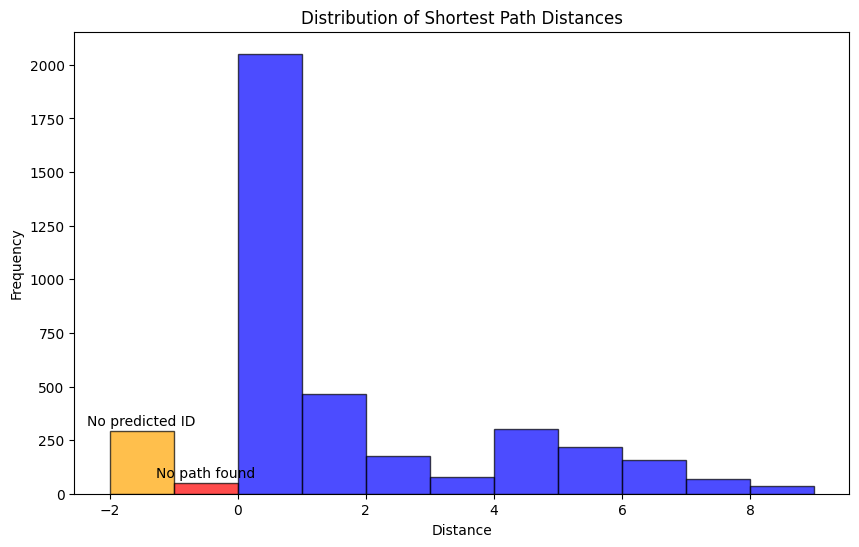

In [595]:
display_shortest_path_predictions(fulltext_path_eval)

And now let us compare the other methods.

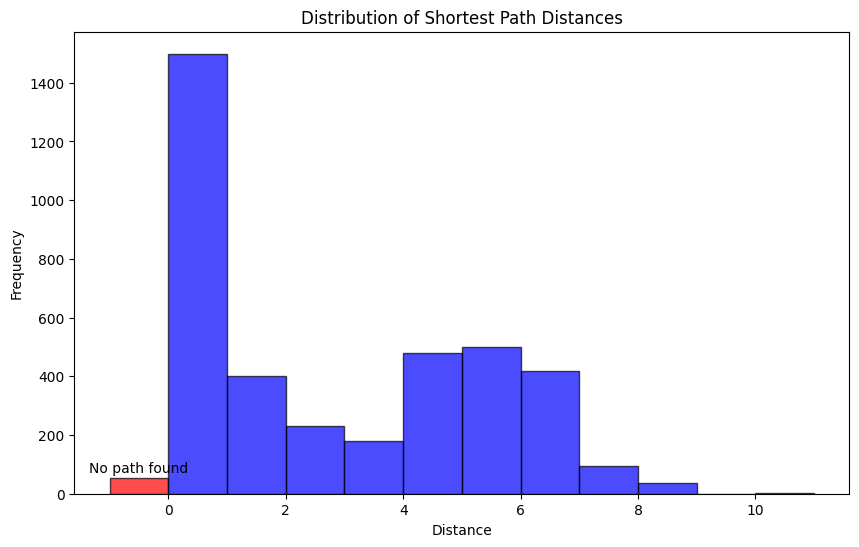

In [599]:
vector_search_eval = get_shortest_path_eval(true_values_vector, predicted_values_vector)
display_shortest_path_predictions(vector_search_eval)

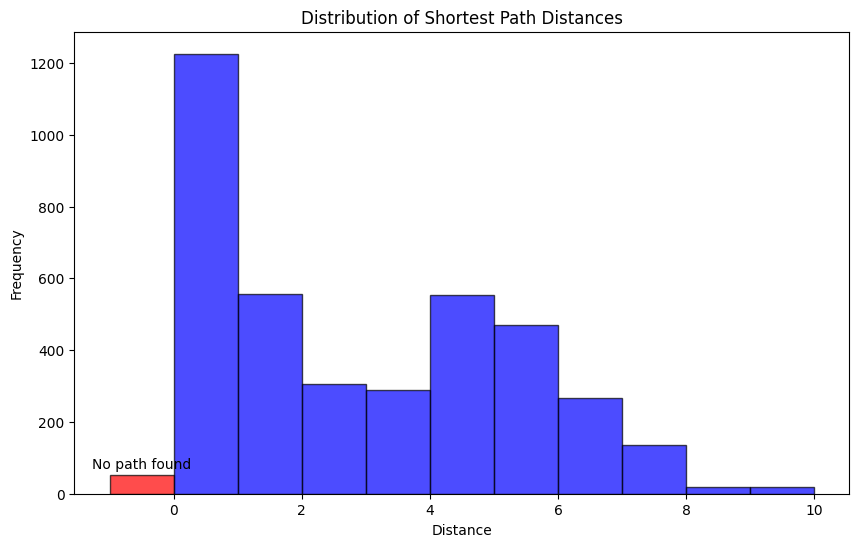

In [600]:
syn_vector_search_eval = get_shortest_path_eval(true_values_syn_vector, predicted_values_syn_vector)
display_shortest_path_predictions(syn_vector_search_eval)

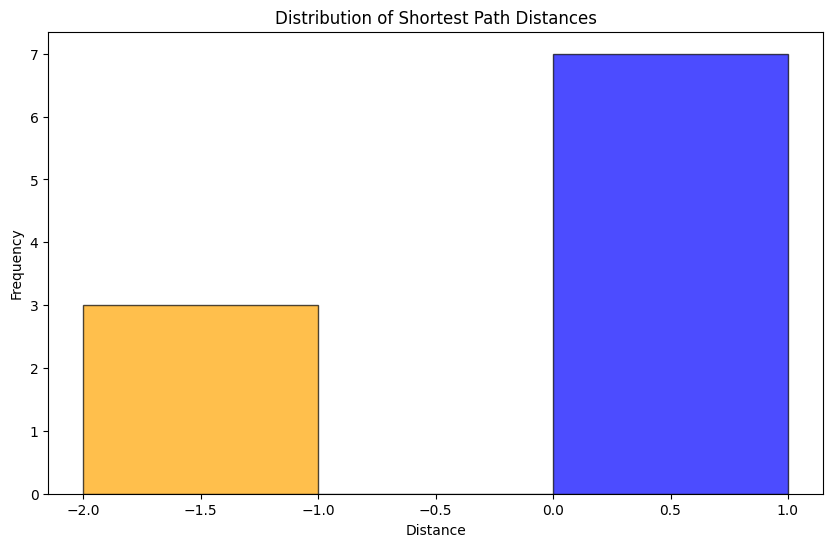

In [603]:
manual_syn_vector_search_eval = get_shortest_path_eval(true_values_syn_vector, predicted_values_syn_vector_manual)
display_shortest_path_predictions(manual_syn_vector_search_eval)

These bar plots allow us to interpret the results of these experiments in a broader manner. It is obvious, that a fulltext search using Cyoher is the most performant, however we have a hypothesis, that a combination of different search tools (fulltext index + vector index) would perform even better. To understand if that hypothesis is correct, we will explore how the predictions from the methods above overlap.